In [1]:
print('Start import')
import socket 
import strax
import straxen
import numpy as np
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import datetime
import pandas as pd
print(
f'''Working on {socket.getfqdn()} with the following versions 
and installation paths:
strax
\tv{strax.__version__}\t{str(strax.__path__[0])}
straxen
\tv{straxen.__version__}\t{str(straxen.__path__[0])}
''')
from multihist import Hist1d, Histdd
import time
import itertools
import os
import math

from scipy import stats
from straxen import units
from scipy.optimize import curve_fit

import peaks_utility as psu
import drift_diffusion_utility as ddu

Start import
Working on midway2-0412.rcc.local with the following versions 
and installation paths:
strax
	v0.14.0	/dali/lgrandi/strax/strax/strax
straxen
	v0.17.0	/dali/lgrandi/strax/straxen/straxen



In [2]:
st = straxen.contexts.xenonnt_online()

In [6]:
dsets = st.select_runs(exclude_tags=('bad','messy'), run_mode='tpc_commissioning')
#                       available=('event_info','peak_basics'))

In [7]:
dsets

,name,number,mode,end,start,tags,livetime,peak_basics_available,raw_records_available,event_info_available
195,015686,15686,tpc_commissioning,2021-04-06 14:10:54.235,2021-04-06 14:04:15.217,,0 days 00:06:39.018000,False,False,False
202,015679,15679,tpc_commissioning,2021-04-06 13:27:03.199,2021-04-06 12:52:34.180,,0 days 00:34:29.019000,True,False,False
203,015678,15678,tpc_commissioning,2021-04-06 12:32:45.584,2021-04-06 12:08:21.198,,0 days 00:24:24.386000,True,False,False
204,015677,15677,tpc_commissioning,2021-04-06 12:06:24.655,2021-04-06 11:58:48.675,abandon,0 days 00:07:35.980000,False,False,False
205,015676,15676,tpc_commissioning,2021-04-06 11:43:07.530,2021-04-06 11:41:46.841,abandon,0 days 00:01:20.689000,False,False,False
...,...,...,...,...,...,...,...,...,...,...
3917,011964,11964,tpc_commissioning,2021-01-22 18:50:58.586,2021-01-22 17:50:56.177,,0 days 01:00:02.409000,True,False,False
3920,011961,11961,tpc_commissioning,2021-01-22 17:50:41.891,2021-01-22 16:50:39.524,,0 days 01:00:02.367000,True,False,False
3924,011957,11957,tpc_commissioning,2021-01-22 16:50:25.240,2021-01-22 15:50:24.774,,0 days 01:00:00.466000,True,False,False
3927,011954,11954,tpc_commissioning,2021-01-22 15:50:10.582,2021-01-22 14:50:10.075,,0 days 01:00:00.507000,True,False,False


In [13]:
dsets_1 = dsets[(dsets.end > pd.to_datetime('01/22/2021')) & (dsets.end < pd.to_datetime('01/27/2021'))
               & (dsets.livetime>=np.timedelta64(60,'m'))]# & (dsets.number<12245) ]
run_1, nn_1 = np.array(dsets_1['name']), len(dsets_1)
print('Number of runs:\n',nn_1)

Number of runs:
 73


In [14]:
dsets_1

,name,number,mode,end,start,tags,livetime,peak_basics_available,raw_records_available,event_info_available
3777,012104,12104,tpc_commissioning,2021-01-26 14:38:45.841,2021-01-26 13:38:42.976,,0 days 01:00:02.865000,True,False,False
3779,012102,12102,tpc_commissioning,2021-01-26 13:38:28.750,2021-01-26 12:38:28.078,,0 days 01:00:00.672000,True,False,False
3782,012099,12099,tpc_commissioning,2021-01-26 11:42:05.127,2021-01-26 10:42:04.163,,0 days 01:00:00.964000,True,False,False
3792,012089,12089,tpc_commissioning,2021-01-26 09:06:18.017,2021-01-26 08:06:16.004,,0 days 01:00:02.013000,True,False,False
3793,012088,12088,tpc_commissioning,2021-01-26 08:05:58.768,2021-01-26 07:05:55.779,,0 days 01:00:02.989000,True,False,False
...,...,...,...,...,...,...,...,...,...,...
3917,011964,11964,tpc_commissioning,2021-01-22 18:50:58.586,2021-01-22 17:50:56.177,,0 days 01:00:02.409000,True,False,False
3920,011961,11961,tpc_commissioning,2021-01-22 17:50:41.891,2021-01-22 16:50:39.524,,0 days 01:00:02.367000,True,False,False
3924,011957,11957,tpc_commissioning,2021-01-22 16:50:25.240,2021-01-22 15:50:24.774,,0 days 01:00:00.466000,True,False,False
3927,011954,11954,tpc_commissioning,2021-01-22 15:50:10.582,2021-01-22 14:50:10.075,,0 days 01:00:00.507000,True,False,False


In [15]:
run_1

array(['012104', '012102', '012099', '012089', '012088', '012084',
       '012081', '012078', '012074', '012071', '012064', '012061',
       '012057', '012054', '012053', '012052', '012051', '012050',
       '012049', '012038', '012037', '012036', '012035', '012033',
       '012032', '012031', '012030', '012029', '012028', '012027',
       '012026', '012025', '012024', '012022', '012020', '012019',
       '012017', '012016', '012015', '012014', '012013', '012012',
       '012011', '012010', '012008', '012007', '012006', '012005',
       '012004', '012001', '012000', '011999', '011997', '011995',
       '011993', '011991', '011987', '011985', '011984', '011982',
       '011980', '011978', '011976', '011975', '011974', '011973',
       '011971', '011970', '011964', '011961', '011957', '011954',
       '011949'], dtype=object)

In [3]:
runs = ['012104', '012102', '012099', '012089', '012088', '012084',
         '012081', '012078', '012074', '012071', '012064', '012061',
         '012054', '012053', '012052', '012051', '012049',
        '012038', '012037', '012036', '012035', '012033',
         '012032', '012031', '012030', '012029', '012028', '012027',
         '012026', '012025', '012024', '012022', '012020', '012019',
         '012017', '012016', '012015', '012014', '012013', '012012',
         '012011', '012010', '012008', '012007', '012006', '012005',
         '012004', '012001', '012000', '011999', '011997',
         '011993', '011991', '011987', '011985', '011984', '011982',
         '011976', '011975', '011974', '011973', '011971', '011970',
         '011964', '011961', '011957', '011954','011949']

In [9]:
def diffusion_analysis(run, area_cut=(5e3,1.1e4), fit_range=(1,1500), plot = False ):
    events = st.get_df(run,'event_info',progress_bar=False)
    #if(plot): ddu.plot_area_width_aft_bkg(events, run)
    mask_awt = ddu.mask_s2_area_width_aft_bkg(events,run,area_cut,width_cut=(200,1.5e4),aft_cut=(0.65,0.77),high = 7, plot=plot)
    events = events[mask_awt]
    vd, vd_err, cathodedt, gatedt, s2shift = ddu.drift_velocity_bkg(events, run, low=500, plot=plot)
    d, d_err = ddu.diffusion_constant_bkg(events,run,fit_range=fit_range,vd = vd,plot=plot)
    if math.isinf(d_err): d_err = 0
    #if ((cathodedt>2000) & (gatedt>2) & (d_err<0.2)): return run, vd, vd_err, d, d_err
    #else: return run, 0, 0, 0, 0
    return run, vd, vd_err, d, d_err, cathodedt, gatedt, s2shift

Drift velocity = 0.602~mm/$\mu$s
Diffusion constant = 46.33 +/- 0.54 cm$^2$/s 


('011949',
 0.6021362375863185,
 0.0024388472610030265,
 46.332584869607054,
 0.5420123878515066,
 2468.9378757515033,
 2.7185929648241203,
 5.296482412060302)

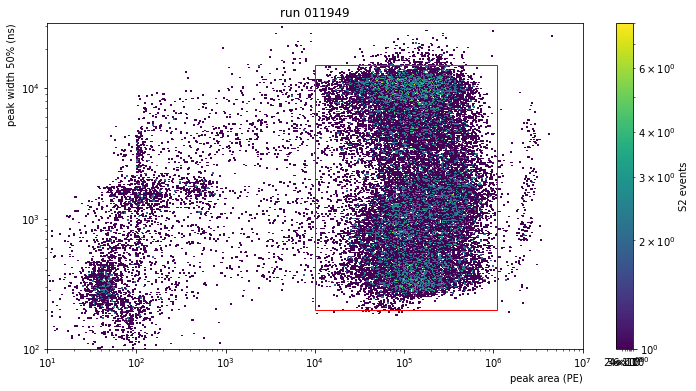

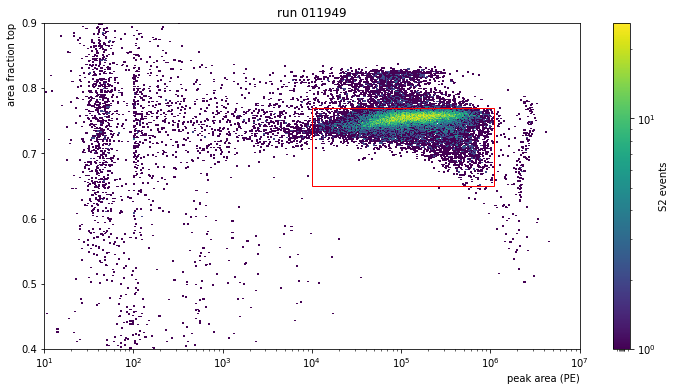

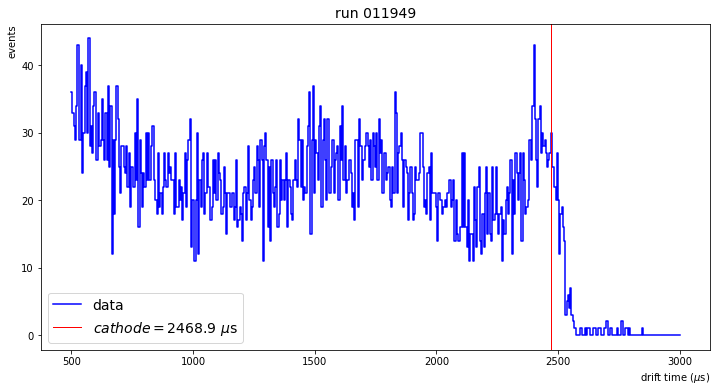

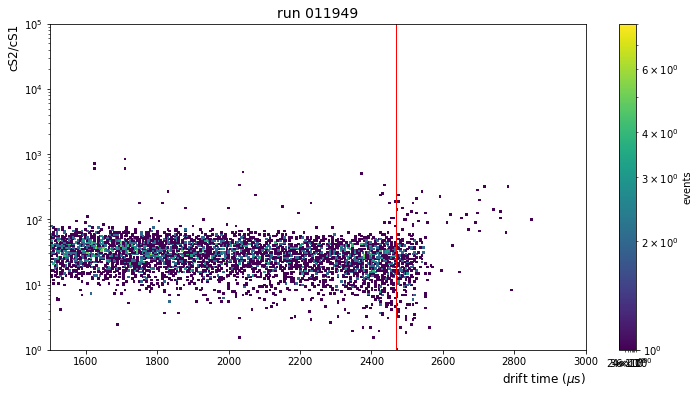

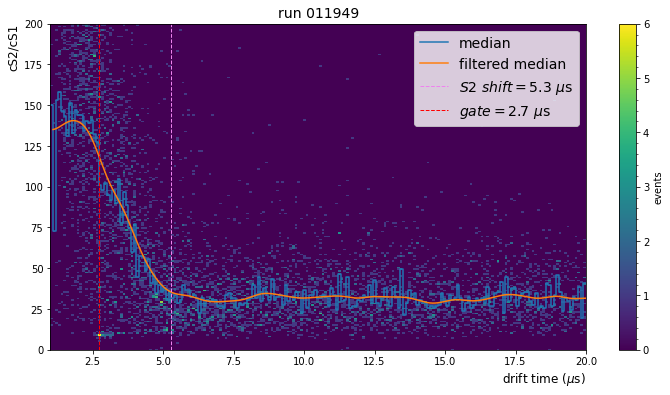

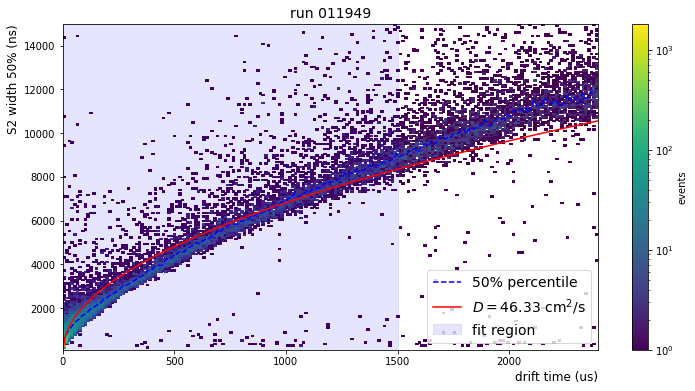

In [11]:
diffusion_analysis(runs[67],area_cut=(1e4,1.1e6),fit_range=(1,1500), plot = True)

Drift velocity = 0.619~mm/$\mu$s
Diffusion constant = 49.16 +/- inf cm$^2$/s 


/dali/lgrandi/strax/miniconda3/envs/strax/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


('012038',
 0.618592352942282,
 0.0025733854449203723,
 49.16265695835901,
 0,
 2403.807615230461,
 3.1959798994974875,
 5.4874371859296485)

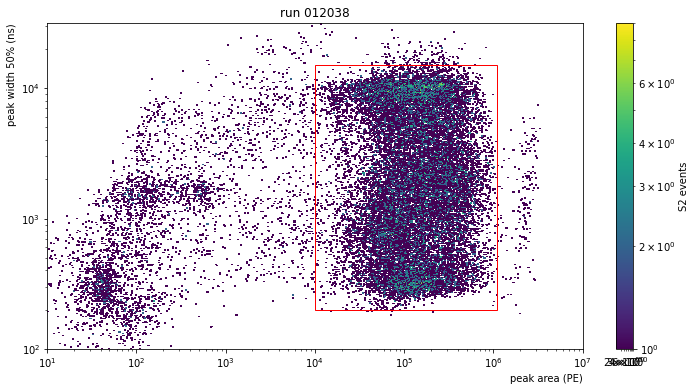

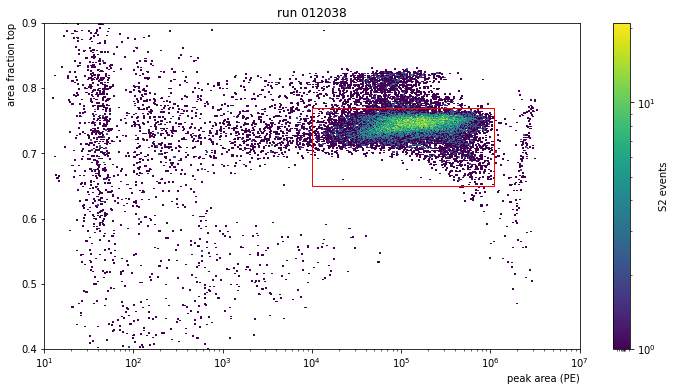

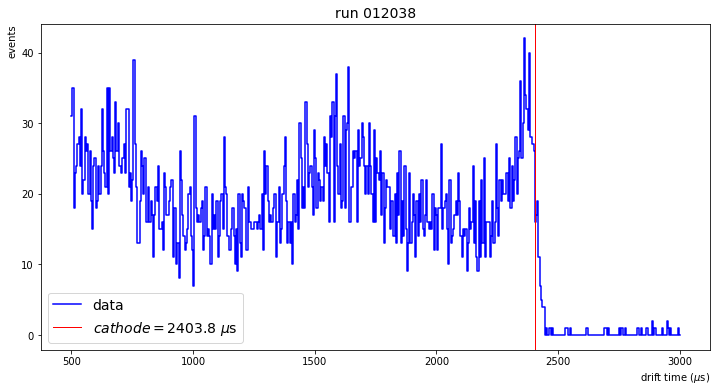

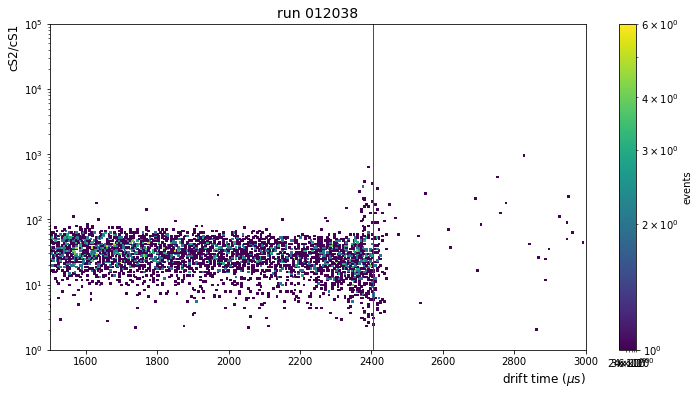

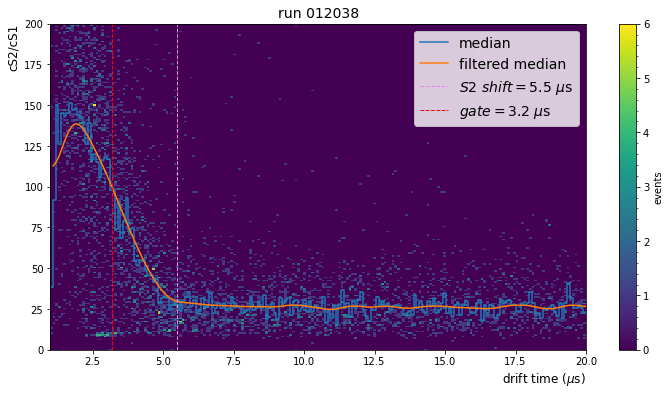

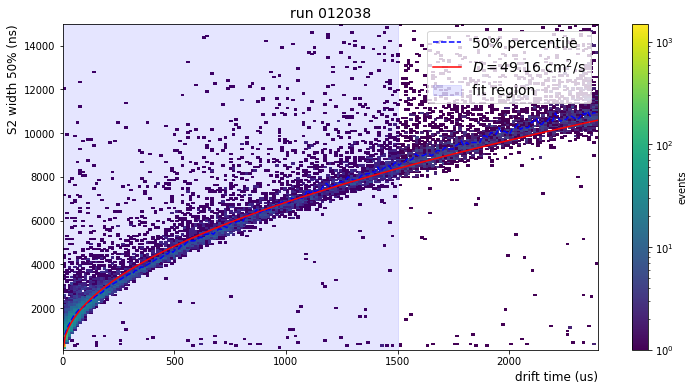

In [12]:
diffusion_analysis(runs[17],area_cut=(1e4,1.1e6),fit_range=(1,1500), plot = True)

Drift velocity = 0.617~mm/$\mu$s
Diffusion constant = 50.72 +/- 0.18 cm$^2$/s 


('012053',
 0.6173040538957707,
 0.0025626848826455035,
 50.719453758817956,
 0.18088522052378592,
 2408.8176352705414,
 3.1959798994974875,
 6.060301507537688)

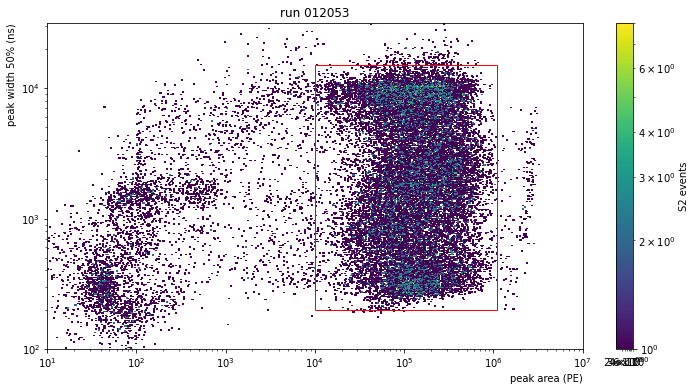

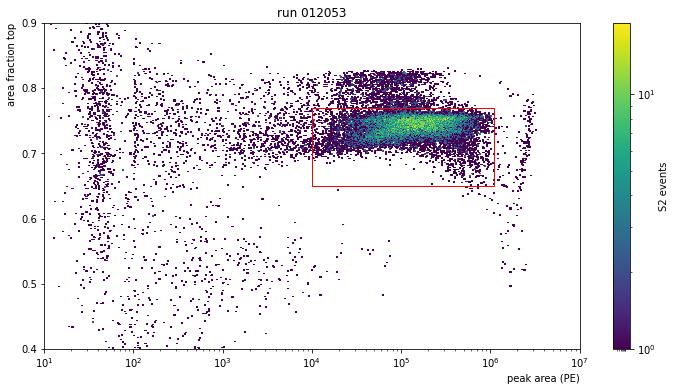

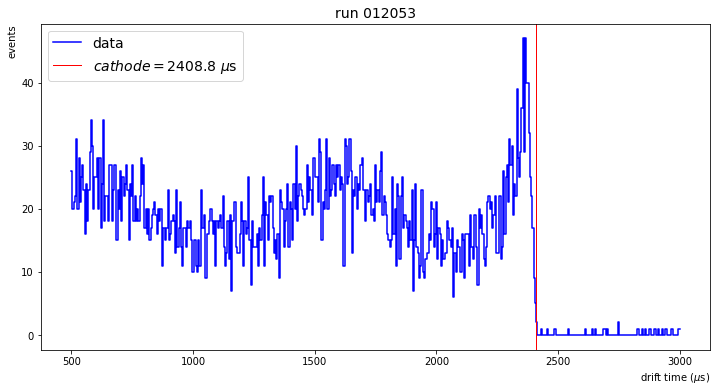

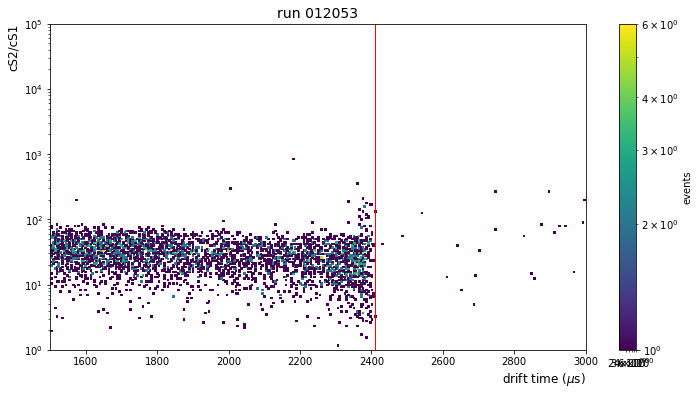

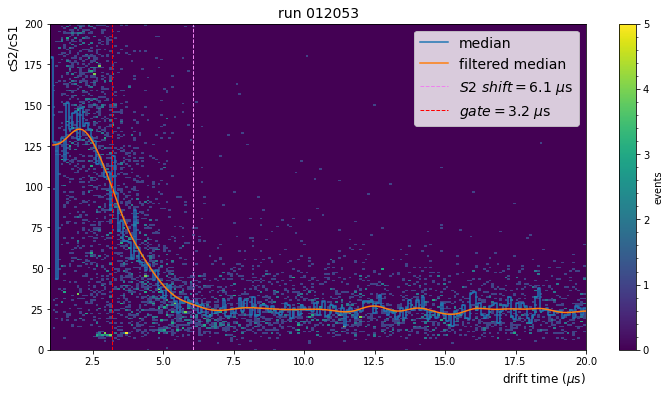

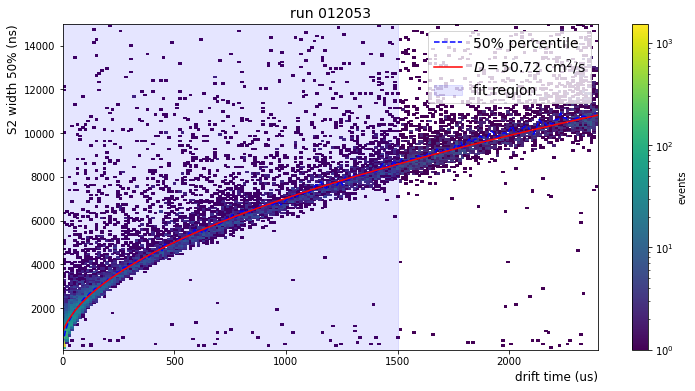

In [13]:
diffusion_analysis(runs[13],area_cut=(1e4,1.1e6),fit_range=(1,1500), plot = True)

In [15]:
nn = len(runs)
print('n. runs',nn)
rr, vd, vd_err, d, d_err = np.zeros(nn), np.zeros(nn), np.zeros(nn), np.zeros(nn), np.zeros(nn)
cc, gg, ss = np.zeros(nn), np.zeros(nn), np.zeros(nn)
for i, run in enumerate(runs):
    rr[i],vd[i],vd_err[i],d[i],d_err[i],cc[i],gg[i],ss[i]=diffusion_analysis(run,area_cut=(1e4,1.1e6),fit_range=(1,1500))

n. runs 68


/dali/lgrandi/strax/miniconda3/envs/strax/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/dali/lgrandi/strax/miniconda3/envs/strax/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/dali/lgrandi/strax/miniconda3/envs/strax/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/dali/lgrandi/strax/miniconda3/envs/strax/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/dali/lgrandi/strax/miniconda3/envs/

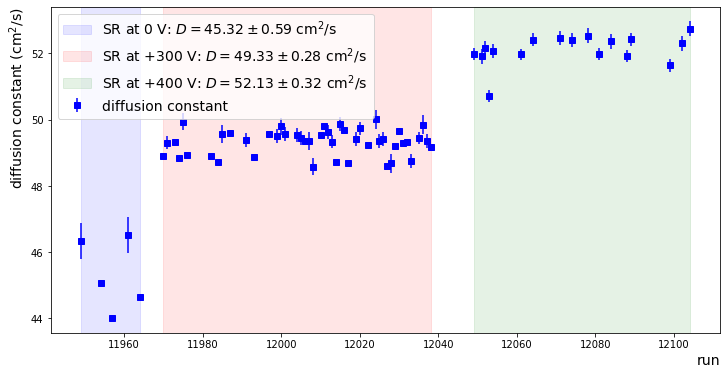

In [16]:
plt.figure(figsize=(12,6))
plt.xlabel("run", ha='right', x=1,fontsize=14)
plt.ylabel("diffusion constant (cm$^2$/s)", ha='right', y=1,fontsize=14)
plt.errorbar(rr, d, yerr = d_err, fmt='s',c='b',label='diffusion constant')
d1, d2, d3 = d[63:], d[17:62], d[:16]
d1_err, d2_err, d3_err = d_err[63:], d_err[17:62], d_err[:16]
mean1, mean2, mean3 = d1[d1>0].mean(), d2[d2>0].mean(), d3[d3>0].mean()
std1 = d1[d1_err>0].std()/np.sqrt(np.size(d1))+d1_err[d1_err>0].mean()
std2 = d2[d2_err>0].std()/np.sqrt(np.size(d2))+d2_err[d2_err>0].mean()
std3 = d3[d3_err>0].std()/np.sqrt(np.size(d3))+d3_err[d3_err>0].mean()
plt.axvspan(int(runs[63]),int(runs[67]), alpha=0.1, color='b',
            label=f'SR at 0 V: $D = {mean1:.2f} \pm {std1:.2f}$ cm$^2$/s')
plt.axvspan(int(runs[17]),int(runs[62]), alpha=0.1, color='r',
            label=f'SR at +300 V: $D = {mean2:.2f} \pm {std2:.2f}$ cm$^2$/s')
plt.axvspan(int(runs[0]),int(runs[16]), alpha=0.1, color='g',
            label=f'SR at +400 V: $D = {mean3:.2f} \pm {std3:.2f}$ cm$^2$/s')
#plt.ylim(40,55)
plt.legend(fontsize=14)

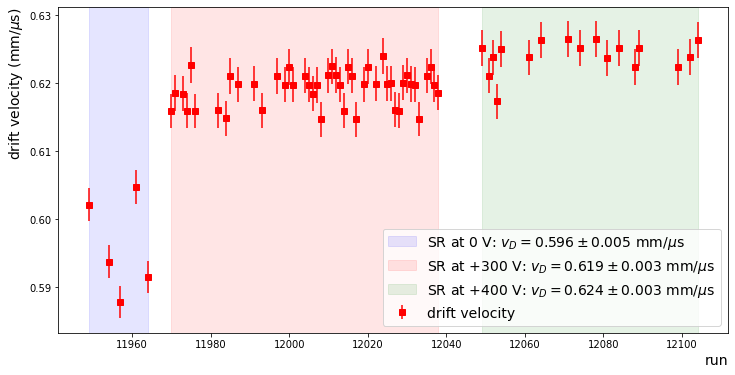

In [17]:
plt.figure(figsize=(12,6))
plt.xlabel("run", ha='right', x=1,fontsize=14)
plt.ylabel("drift velocity (mm/$\mu$s)", ha='right', y=1,fontsize=14)
plt.errorbar(rr, vd, yerr = vd_err, fmt='s',c='r',label='drift velocity')
vd1, vd2, vd3 = vd[63:], vd[17:62], vd[:16]
vd1_err, vd2_err, vd3_err = vd_err[63:], vd_err[17:62], vd_err[:16]
mean1, mean2, mean3 = vd1[vd1>0].mean(), vd2[vd2>0].mean(), vd3[vd3>0].mean()
std1 = vd1[vd1_err>0].std()/np.sqrt(np.size(vd1))+vd1_err[vd1_err>0].mean()
std2 = vd2[vd2_err>0].std()/np.sqrt(np.size(vd2))+vd2_err[vd2_err>0].mean()
std3 = vd3[vd3_err>0].std()/np.sqrt(np.size(vd3))+vd3_err[vd3_err>0].mean()
plt.axvspan(int(runs[63]),int(runs[67]), alpha=0.1, color='b',
            label=f'SR at 0 V: $v_D = {mean1:.3f} \pm {std1:.3f}$ mm/$\mu$s')
plt.axvspan(int(runs[17]),int(runs[62]), alpha=0.1, color='r',
            label=f'SR at +300 V: $v_D = {mean2:.3f} \pm {std2:.3f}$ mm/$\mu$s')
plt.axvspan(int(runs[0]),int(runs[16]), alpha=0.1, color='g',
            label=f'SR at +400 V: $v_D = {mean3:.3f} \pm {std3:.3f}$ mm/$\mu$s')
#plt.ylim(40,55)
plt.legend(fontsize=14)

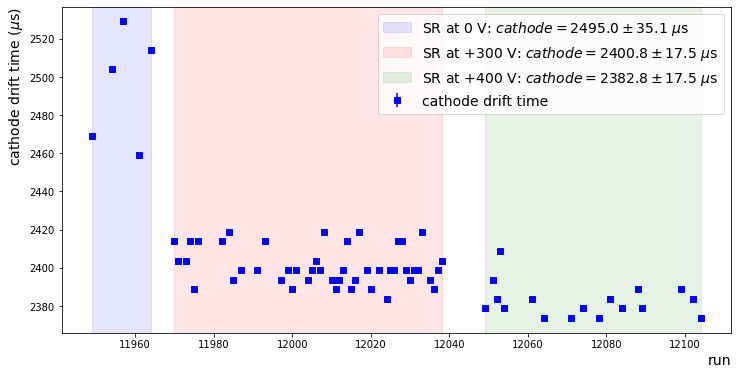

In [18]:
plt.figure(figsize=(12,6))
plt.xlabel("run", ha='right', x=1,fontsize=14)
plt.ylabel("cathode drift time ($\mu$s)", ha='right', y=1,fontsize=14)
plt.errorbar(rr, cc, yerr = 0, fmt='s',c='b',label='cathode drift time')
c1, c2, c3 = cc[63:], cc[17:62], cc[:16]
mean1, mean2, mean3 = c1[c1>0].mean(), c2[c2>0].mean(), c3[c3>0].mean()
std1 = (np.max(c1)-np.min(c1))/2
std2 = (np.max(c2)-np.min(c2))/2
std3 = (np.max(c3)-np.min(c3))/2
plt.axvspan(int(runs[63]),int(runs[67]), alpha=0.1, color='b',
            label=f'SR at 0 V: $cathode = {mean1:.1f} \pm {std1:.1f}~\mu$s')
plt.axvspan(int(runs[17]),int(runs[62]), alpha=0.1, color='r',
            label=f'SR at +300 V: $cathode = {mean2:.1f} \pm {std2:.1f}~\mu$s')
plt.axvspan(int(runs[0]),int(runs[16]), alpha=0.1, color='g',
            label=f'SR at +400 V: $cathode = {mean3:.1f} \pm {std3:.1f}~\mu$s')
#plt.ylim(40,55)
plt.legend(fontsize=14)

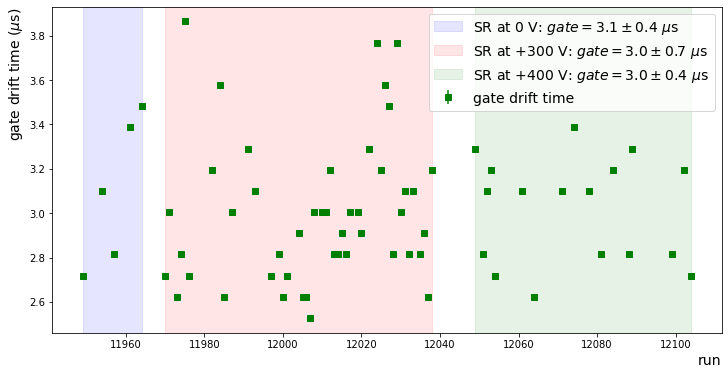

In [19]:
plt.figure(figsize=(12,6))
plt.xlabel("run", ha='right', x=1,fontsize=14)
plt.ylabel("gate drift time ($\mu$s)", ha='right', y=1,fontsize=14)
plt.errorbar(rr, gg, yerr = 0, fmt='s',c='g',label='gate drift time')
g1, g2, g3 = gg[63:], gg[17:62], gg[:16]
mean1, mean2, mean3 = g1[g1>0].mean(), g2[g2>0].mean(), g3[g3>0].mean()
std1 = (np.max(g1)-np.min(g1))/2
std2 = (np.max(g2)-np.min(g2))/2
std3 = (np.max(g3)-np.min(g3))/2
plt.axvspan(int(runs[63]),int(runs[67]), alpha=0.1, color='b',
            label=f'SR at 0 V: $gate = {mean1:.1f} \pm {std1:.1f}~\mu$s')
plt.axvspan(int(runs[17]),int(runs[62]), alpha=0.1, color='r',
            label=f'SR at +300 V: $gate = {mean2:.1f} \pm {std2:.1f}~\mu$s')
plt.axvspan(int(runs[0]),int(runs[16]), alpha=0.1, color='g',
            label=f'SR at +400 V: $gate = {mean3:.1f} \pm {std3:.1f}~\mu$s')
#plt.ylim(40,55)
plt.legend(fontsize=14)

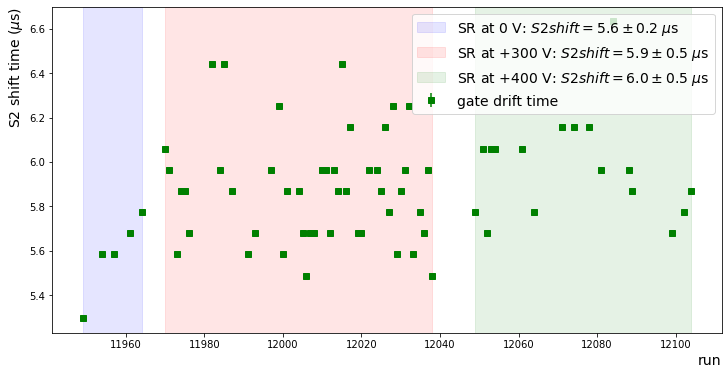

In [20]:
### S2 shift time
plt.figure(figsize=(12,6))
plt.xlabel("run", ha='right', x=1,fontsize=14)
plt.ylabel("S2 shift time ($\mu$s)", ha='right', y=1,fontsize=14)
plt.errorbar(rr, ss, yerr = 0, fmt='s',c='g',label='gate drift time')
g1, g2, g3 = ss[63:], ss[17:62], ss[:16]
mean1, mean2, mean3 = g1[g1>0].mean(), g2[g2>0].mean(), g3[g3>0].mean()
std1 = (np.max(g1)-np.min(g1))/2
std2 = (np.max(g2)-np.min(g2))/2
std3 = (np.max(g3)-np.min(g3))/2
plt.axvspan(int(runs[63]),int(runs[67]), alpha=0.1, color='b',
            label=f'SR at 0 V: $S2 shift = {mean1:.1f} \pm {std1:.1f}~\mu$s')
plt.axvspan(int(runs[17]),int(runs[62]), alpha=0.1, color='r',
            label=f'SR at +300 V: $S2 shift = {mean2:.1f} \pm {std2:.1f}~\mu$s')
plt.axvspan(int(runs[0]),int(runs[16]), alpha=0.1, color='g',
            label=f'SR at +400 V: $S2 shift = {mean3:.1f} \pm {std3:.1f}~\mu$s')
#plt.ylim(40,55)
plt.legend(fontsize=14)

<Figure size 576x324 with 0 Axes>

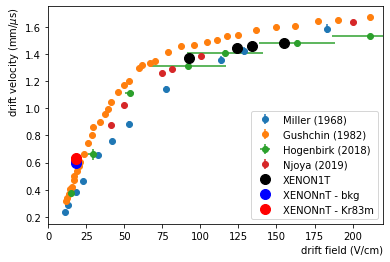

In [21]:
with open("DriftVelocity.txt") as f:
    data = f.read()
data = data.split('\n')
ind = [row.split('\t')[0] for row in data]
dt = [row.split('\t')[1] for row in data]
dv = [row.split('\t')[2] for row in data]
dt, dv = np.array(dt, dtype=np.float32), np.array(dv, dtype=np.float32)

with open("DriftVelocity-Hogenbirk.txt") as f:
    data = f.read()
data = data.split('\n')
ff = [row.split(' ')[0] for row in data]
dd = [row.split(' ')[1] for row in data]
fe = [row.split(' ')[2] for row in data]
de = [row.split(' ')[3] for row in data]
ff, fe = np.array(ff, dtype=np.float32), np.array(fe, dtype=np.float32)
dd, de = np.array(dd, dtype=np.float32), np.array(de, dtype=np.float32)

with open("DriftVelocity-Njoya.txt") as f:
    data = f.read()
data = data.split('\n')
f_n = [row.split(' ')[0] for row in data]
d_n = [row.split(' ')[1] for row in data]
d_n, f_n = np.array(d_n, dtype=np.float32), np.array(f_n, dtype=np.float32)

with open("DriftVelocity-Gushchin.txt") as f:
    data = f.read()
data = data.split('\n')
f_g = [row.split(' ')[0] for row in data]
d_g = [row.split(' ')[1] for row in data]
d_g, f_g = np.array(d_g, dtype=np.float32), np.array(f_g, dtype=np.float32)

field_nT, vd_nT, vd_nT_err = [18.3,18.3], [0.63,0.631], [0.006,0.003]
field_nTb, vd_nTb, vd_nTb_err = [18.3,18.3,18.3], [0.596,0.619, 0.622], [0.005,0.003,0.003]
field_1T, vd_1T = [155,134,124,92.8], [1.482,1.456,1.440,1.371]

plt.figure(figsize=(8,4.5))
fig, ax = plt.subplots()
plt.xlabel('drift field (V/cm)',ha='right',x=1)
plt.ylabel('drift velocity (mm/$\mu$s)',ha='right',y=1)
#plt.xscale('log')
plt.errorbar(dt,dv,yerr=dv*0.02, fmt='o', label='Miller (1968)')
plt.errorbar(f_g,d_g,yerr=0, fmt='o', label='Gushchin (1982)')
plt.errorbar(ff,dd,xerr=fe,yerr=de, fmt='o', label='Hogenbirk (2018)')
plt.errorbar(f_n,d_n,yerr=0, fmt='o', label='Njoya (2019)')
plt.errorbar(field_1T, vd_1T, yerr=0,fmt='o',c='black',ms=10,lw=0,label='XENON1T')
plt.errorbar(field_nTb,vd_nTb,yerr=vd_nTb_err,fmt='o',c='b',ms=10,lw=0,label='XENONnT - bkg')
plt.errorbar(field_nT, vd_nT, yerr=vd_nT_err,fmt='o',c='r',ms=10,lw=0,label='XENONnT - Kr83m')
plt.xlim(0,220)
plt.ylim(0.15,1.75)
plt.legend()
"""
axin = ax.inset_axes([0.02, 0.57, 0.12, 0.38])
axin.errorbar(dt,dv,yerr=dv*0.02, fmt='o', label='Miller (1968)')
axin.errorbar(f_g,d_g,yerr=0, fmt='o', label='Gushchin (1982)')
axin.errorbar(ff,dd,xerr=fe,yerr=de, fmt='o', label='Hogenbirk (2018)')
axin.errorbar(f_n,d_n,yerr=0, fmt='o', label='Njoya (2019)')
axin.errorbar(field_nTb,vd_nTb,yerr=vd_nTb_err,fmt='o',c='b',ms=10,lw=0,label='XENONnT - bkg')
axin.errorbar(field_nT, vd_nT, yerr=vd_nT_err,fmt='o',c='r',ms=10,lw=0,label='XENONnT - Kr83m')
axin.set_xlim(15.3,21.3)
axin.set_ylim(0.5,0.65)
axin.set_xticklabels('')
axin.set_yticklabels('')
ax.indicate_inset_zoom(axin)
"""
plt.savefig('driftvelocity-comparison.png',dpi=800)

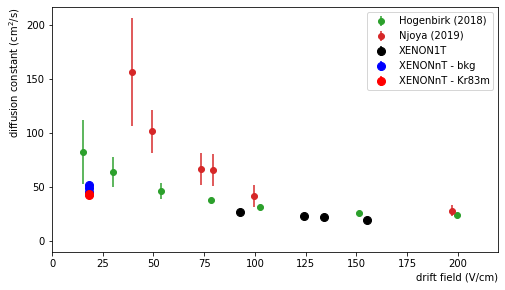

In [92]:
with open("DiffusionConstantHogenbirk.txt") as f:
    data = f.read()
data = data.split('\n')
ff = [row.split(' ')[0] for row in data]
dd = [row.split(' ')[1] for row in data]
de = [row.split(' ')[2] for row in data]
ff, dd, de = np.array(ff, dtype=np.float32), np.array(dd, dtype=np.float32), np.array(de, dtype=np.float32)
with open("DiffusionConstant-Nioya.txt") as f:
    data = f.read()
data = data.split('\n')
ffn = [row.split(' ')[0] for row in data]
ddn = [row.split(' ')[1] for row in data]
den = [row.split(' ')[2] for row in data]
ffn, ddn, den = np.array(ffn, dtype=np.float32), np.array(ddn, dtype=np.float32), np.array(den, dtype=np.float32)
field_1T = [155,134,124,92.8]
diff_1T = [19.2, 21.9, 22.8, 26.8]
field_nT = [18.3, 18.3]
field_nTb = [18.3, 18.3, 18.3]
diff_nT = [43.0, 42.7]
diff_nT_err = [0.06, 0.02]
diff_nTb = [45.3, 49.3, 52.1]
diff_nTb_err = [0.6, 0.3, 0.3]

plt.figure(figsize=(8,4.5))
plt.plot(0,0)
plt.plot(0,0)
plt.errorbar(ff,dd,yerr=de, fmt='o', label='Hogenbirk (2018)')
plt.errorbar(ffn,ddn,yerr=den, fmt='o', label='Njoya (2019)')
plt.errorbar(field_1T,diff_1T,yerr=0.8,fmt='o',ms=8,color='black',label='XENON1T')
plt.errorbar(field_nTb,diff_nTb,yerr=diff_nTb_err,fmt='o',ms=8,color='b',label='XENONnT - bkg')
plt.errorbar(field_nT,diff_nT,yerr=diff_nT_err,fmt='o',ms=8,color='r',label='XENONnT - Kr83m')
plt.xlabel("drift field (V/cm)", ha='right', x=1)
plt.ylabel("diffusion constant (cm$^2$/s)", ha='right', y=1)
plt.xlim(0,220)
plt.legend()
plt.savefig('diffusionconstant-comparison.png',dpi=800)